# Building a prediction model

### Import libraries and load the 'cleaned' dataset

In [28]:
import pandas as pd
import numpy as np
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
import joblib
import os

In [2]:
# Read  dataset
data = pd.read_csv('../data/cleaned/data_cleaned.csv')

In [3]:
data.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,False,False
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,False,False
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,4,1,9,3,Returning_Visitor,False,False
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,Feb,3,2,2,4,Returning_Visitor,False,False
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,Feb,3,3,1,4,Returning_Visitor,True,False


### Checking for class imbalance

In [4]:
# Check class distribution in 'Revenue'
class_counts = data['Revenue'].value_counts(normalize=True) * 100

# Print class imbalance percentage
print("Class Imbalance in Revenue:")
print(class_counts)

Class Imbalance in Revenue:
Revenue
False    84.367063
True     15.632937
Name: proportion, dtype: float64


## Feature engineering

In [5]:
# Handling outliers with Log Transformation
data["PageValues"] = np.log1p(data["PageValues"])

In [6]:
# Categorical Encoding (One-Hot Encoding for categorical variables)
categorical_features = ["Month", "OperatingSystems", "Browser", "Region", "TrafficType", "VisitorType"]
data_encoded = pd.get_dummies(data, columns=categorical_features, drop_first=True)

In [7]:
# Define features and target
X = data_encoded.drop(columns=['Revenue'])
y = data_encoded['Revenue'].astype(int)

In [8]:
# Apply SMOTE for oversampling the minority class
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

In [9]:
# Aggregation Features (e.g., Total duration spent)
X_resampled['Total_Duration'] = (
    X_resampled['Administrative_Duration'] + 
    X_resampled['Informational_Duration'] + 
    X_resampled['ProductRelated_Duration']
)

In [10]:
# Interaction Features (e.g., ProductRelated * PageValues)
X_resampled['Product_Page_Interaction'] = X_resampled['ProductRelated'] * X_resampled['PageValues']

### View dataset after feature engineering

In [11]:
data_encoded.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,...,TrafficType_13,TrafficType_14,TrafficType_15,TrafficType_16,TrafficType_17,TrafficType_18,TrafficType_19,TrafficType_20,VisitorType_Other,VisitorType_Returning_Visitor
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,...,False,False,False,False,False,False,False,False,False,True
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,...,False,False,False,False,False,False,False,False,False,True
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,...,False,False,False,False,False,False,False,False,False,True
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,...,False,False,False,False,False,False,False,False,False,True
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,...,False,False,False,False,False,False,False,False,False,True


In [12]:
data_encoded.shape

(12205, 69)

## Prediction modeling

In [13]:
# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

In [14]:
# Train Random Forest Classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [15]:
# Predictions
y_pred = clf.predict(X_test)

In [16]:
# Evaluate Model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print("Classification Report:\n", report)

Accuracy: 0.9378
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.92      0.94      2038
           1       0.93      0.95      0.94      2081

    accuracy                           0.94      4119
   macro avg       0.94      0.94      0.94      4119
weighted avg       0.94      0.94      0.94      4119



### Feature importance

In [18]:
# Tree-Based Feature Importance
feature_importances = pd.Series(clf.feature_importances_, index=X_train.columns)
feature_importances = feature_importances.sort_values(ascending=False)

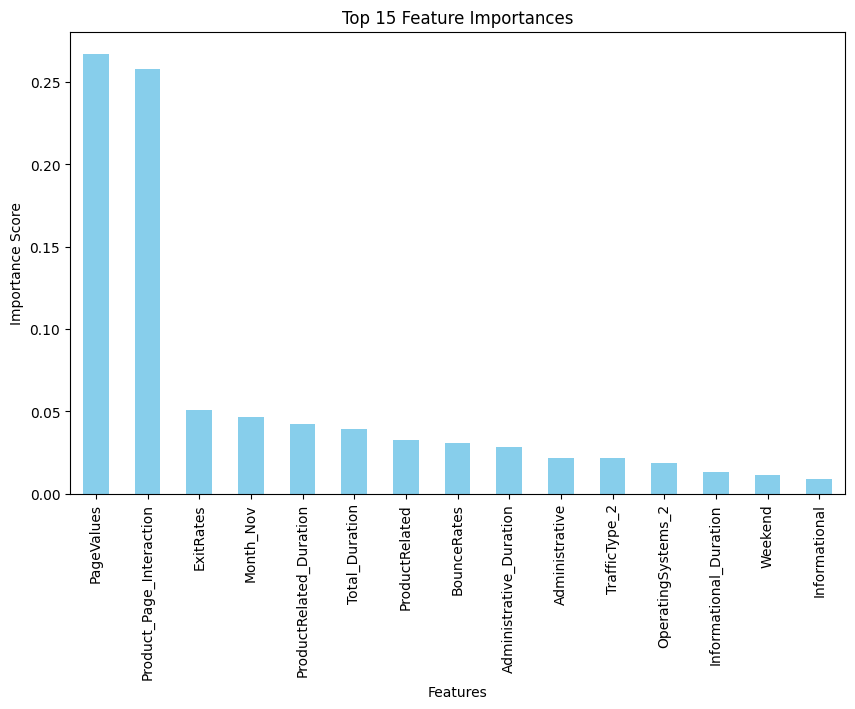

In [37]:
# Plot Feature Importance
plt.figure(figsize=(10, 6))
feature_importances[:15].plot(kind='bar', color='skyblue')
plt.title("Top 15 Feature Importances")
plt.ylabel("Importance Score")
plt.xlabel("Features")
plt.savefig('../Reports/figures/Feature Importance.png', dpi=300, bbox_inches='tight')
plt.show()

In [29]:
# Save the trained model
joblib.dump(clf, '../model/random_forest_model.pkl')

['../model/random_forest_model.pkl']

### Prediction testing with a sample test

In [30]:
# Load the saved model and test its prediction capability
loaded_model = joblib.load('../model/random_forest_model.pkl')

In [36]:
# Ensure test data has same features as training data
missing_cols = set(X_train.columns) - set(X_test.columns)
for col in missing_cols:
    X_test[col] = 0  # Add missing columns with default value
X_test = X_test[X_train.columns]  # Ensure column order matches

sample_input = X_test.iloc[0:1]  # Take a single sample from the test set
sample_prediction = loaded_model.predict(sample_input)
print(f"Predicted Revenue for sample input: {sample_prediction[0]}")

Predicted Revenue for sample input: 0
